# Néobanque : Modèle IA de scoring crédit

## Préparation

### Imports nécessaires

In [2]:
import zipfile

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

## Données

### Chargement des données

In [3]:
# Extraction du ZIP
with zipfile.ZipFile("application_train.zip", "r") as zip_ref:
    zip_ref.extractall(".")

In [4]:
# Charger les données d'entraînement
train_data = pd.read_csv("application_train.csv")
print(train_data.head())

   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0             

Pour rappel, la cible est la colonne TARGET, dont les valeurs sont :
- 1 pour les clients qui ont eu des difficultés de paiement
- 0 pour les autres

### Sélection des données

Notre table comprend 122 colonnes, dont la cible et l'identifiant. Cela fait beaucoup trop de variables à prendre en compte, nous ferons une analyse permettant de se séparer de ce qui ne nous est pas utile plus bas dans ce notebook.

In [5]:
# Afficher toutes les colonnes
print("Liste de toutes les colonnes dans le fichier application_train.csv :")
for i, column in enumerate(train_data.columns):
    print(f"{i + 1}. {column}")

Liste de toutes les colonnes dans le fichier application_train.csv :
1. SK_ID_CURR
2. TARGET
3. NAME_CONTRACT_TYPE
4. CODE_GENDER
5. FLAG_OWN_CAR
6. FLAG_OWN_REALTY
7. CNT_CHILDREN
8. AMT_INCOME_TOTAL
9. AMT_CREDIT
10. AMT_ANNUITY
11. AMT_GOODS_PRICE
12. NAME_TYPE_SUITE
13. NAME_INCOME_TYPE
14. NAME_EDUCATION_TYPE
15. NAME_FAMILY_STATUS
16. NAME_HOUSING_TYPE
17. REGION_POPULATION_RELATIVE
18. DAYS_BIRTH
19. DAYS_EMPLOYED
20. DAYS_REGISTRATION
21. DAYS_ID_PUBLISH
22. OWN_CAR_AGE
23. FLAG_MOBIL
24. FLAG_EMP_PHONE
25. FLAG_WORK_PHONE
26. FLAG_CONT_MOBILE
27. FLAG_PHONE
28. FLAG_EMAIL
29. OCCUPATION_TYPE
30. CNT_FAM_MEMBERS
31. REGION_RATING_CLIENT
32. REGION_RATING_CLIENT_W_CITY
33. WEEKDAY_APPR_PROCESS_START
34. HOUR_APPR_PROCESS_START
35. REG_REGION_NOT_LIVE_REGION
36. REG_REGION_NOT_WORK_REGION
37. LIVE_REGION_NOT_WORK_REGION
38. REG_CITY_NOT_LIVE_CITY
39. REG_CITY_NOT_WORK_CITY
40. LIVE_CITY_NOT_WORK_CITY
41. ORGANIZATION_TYPE
42. EXT_SOURCE_1
43. EXT_SOURCE_2
44. EXT_SOURCE_3
45. APA

### Analyses

#### Valeurs manquantes

Tout d'abord, regardons si certaines colonnes ne sont pas inutiles de part leurs valeurs trop souvent manquantes. Nous considèrerons que toute colonne ayant plus de 60% de données manquantes est inutile pour notre modèle.

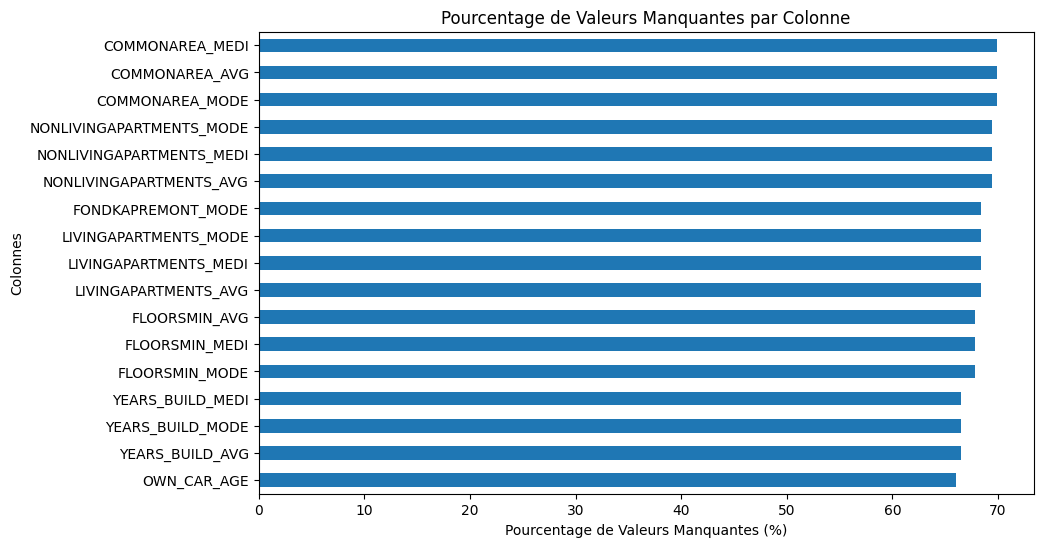

In [6]:
# Visualiser les colonnes avec le plus de valeurs manquantes
plt.figure(figsize=(10, 6))
missing_percent = train_data.isnull().mean() * 100
missing_percent = missing_percent[missing_percent >= 60].sort_values(ascending=True)
missing_percent.plot(kind="barh")
plt.title("Pourcentage de Valeurs Manquantes par Colonne")
plt.xlabel("Pourcentage de Valeurs Manquantes (%)")
plt.ylabel("Colonnes")
plt.show()

In [7]:
# Supprimer les colonnes avec le plus de valeurs manquantes
cols_to_drop = missing_percent[missing_percent >= 60].index
train_data_reduced = train_data.drop(columns=cols_to_drop)
print(f"Colonnes supprimées pour plus de 60% de valeurs manquantes : {list(cols_to_drop)}")
print(f"\nNombre de colonnes restantes : {len(train_data_reduced.columns)}")

Colonnes supprimées pour plus de 60% de valeurs manquantes : ['OWN_CAR_AGE', 'YEARS_BUILD_AVG', 'YEARS_BUILD_MODE', 'YEARS_BUILD_MEDI', 'FLOORSMIN_MODE', 'FLOORSMIN_MEDI', 'FLOORSMIN_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAPARTMENTS_MODE', 'FONDKAPREMONT_MODE', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MODE', 'COMMONAREA_MODE', 'COMMONAREA_AVG', 'COMMONAREA_MEDI']

Nombre de colonnes restantes : 105


### Séparation des variables et préparation des données

In [8]:
# Séparer les variables et la cible pour l'ensemble d'entraînement
X_train = train_data.drop(columns=["TARGET", "SK_ID_CURR"])  # On enlève la cible et l'identifiant
y_train = train_data["TARGET"]  # Cible

### Analyses

#### Label Encoding 

On encode les colonnes catégorielles en label encoding pour l'analyse., cela est plus adapté que le one-hot encoding, qui sera utilisé plutôt pour l'entraînement du modèle plus loin dans ce notebook.

In [9]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = X_train.select_dtypes(include=["object"]).columns
X_train_encoded = X_train.copy()
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X_train_encoded[col] = le.fit_transform(X_train[col].astype(str))
    label_encoders[col] = le

#### Corrélation


Analyse de corrélation des colonnes numériques :


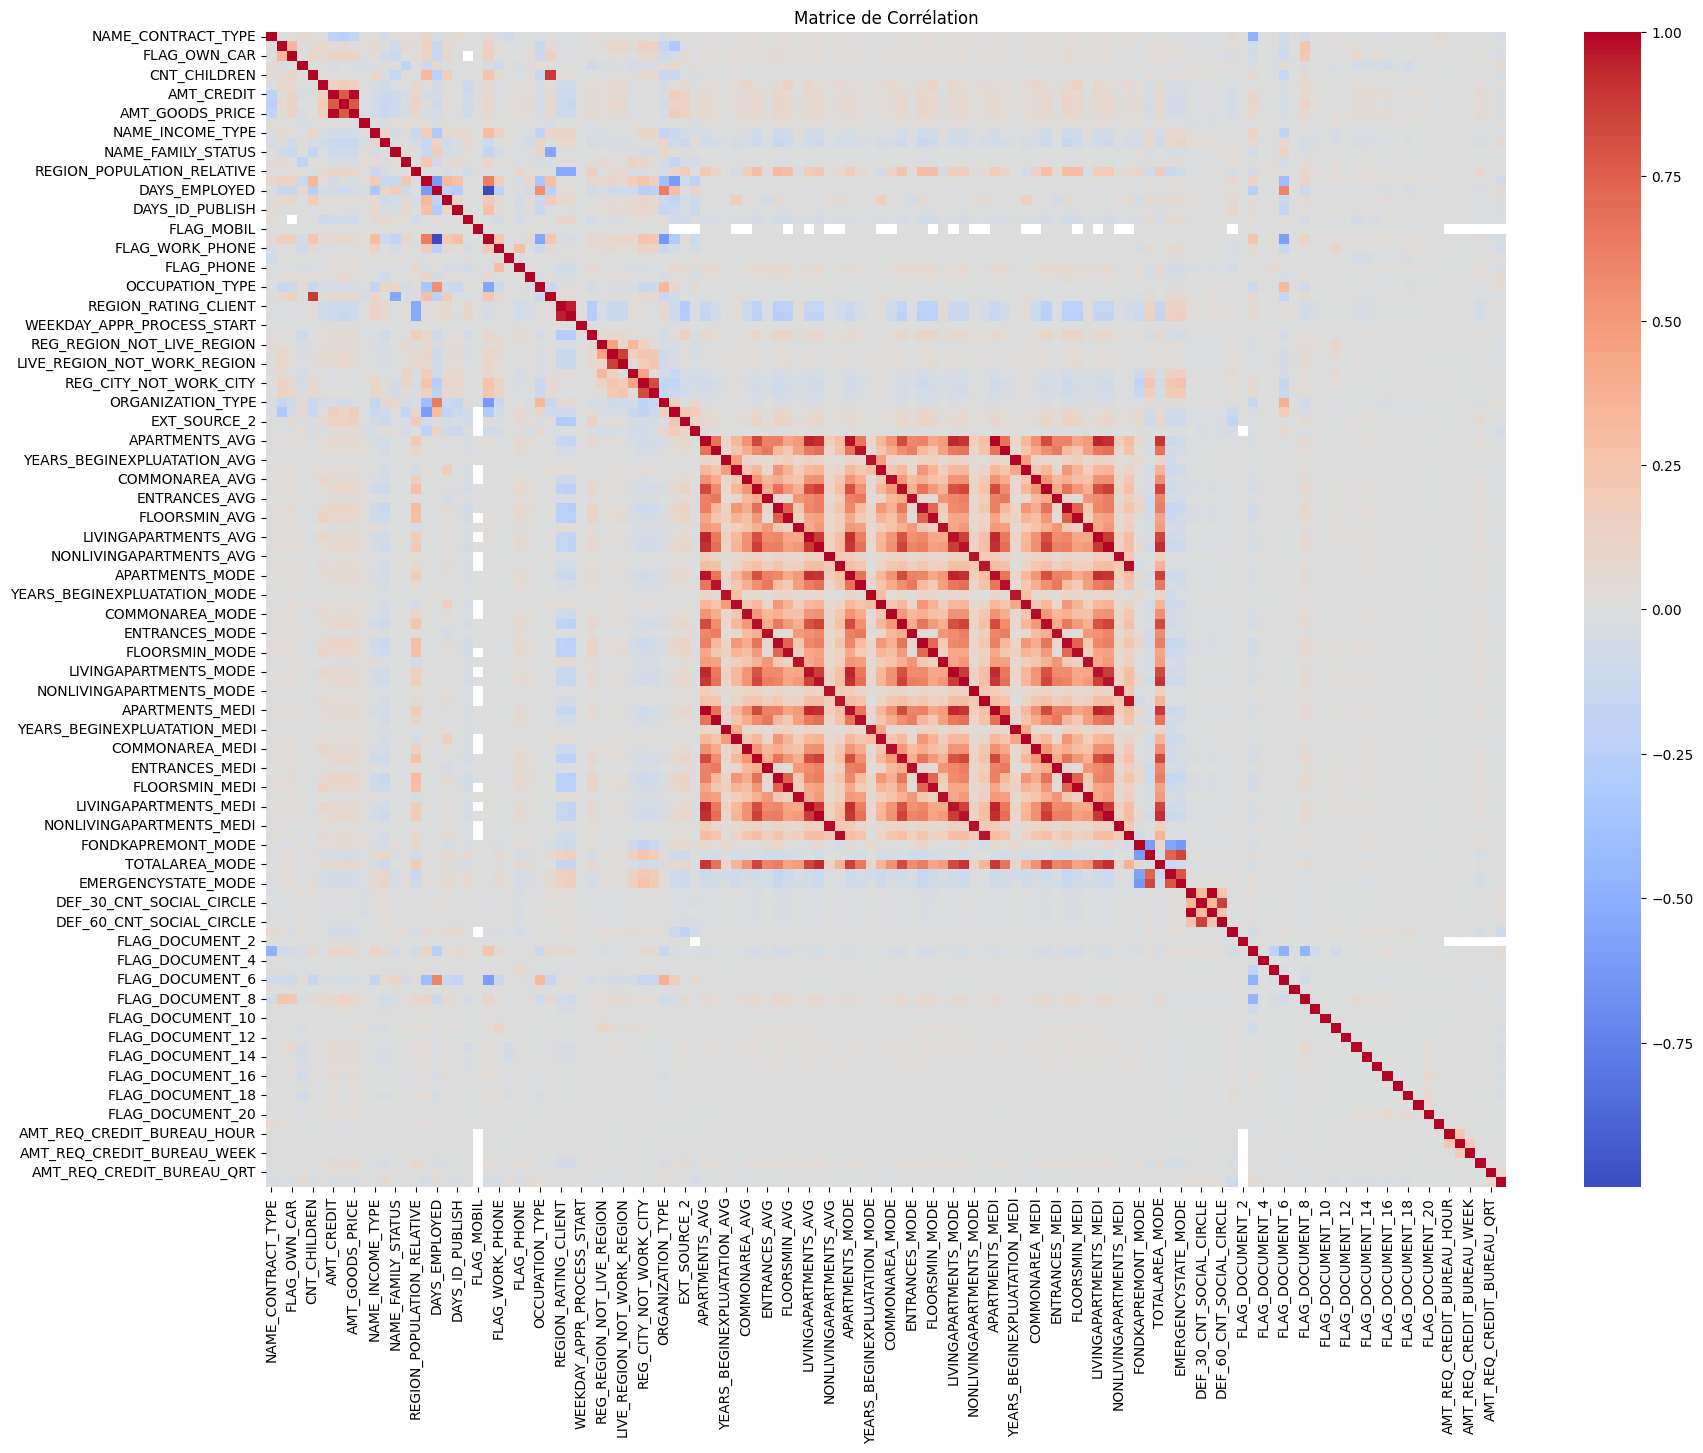

In [10]:
print("\nAnalyse de corrélation des colonnes numériques :")
corr_matrix = X_train_encoded.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de Corrélation")
plt.show()

Identifions maintenant les paires de colonnes fortement corrélées (corrélation > 0.8) :

In [11]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_pairs = [
    (col1, col2) for col1 in upper.columns for col2 in upper.index if upper.loc[col1, col2] > 0.9
]
print("\nPaires de colonnes fortement corrélées (corrélation > 0.9) :")
for pair in high_corr_pairs:
    print(pair)


Paires de colonnes fortement corrélées (corrélation > 0.9) :
('AMT_CREDIT', 'AMT_GOODS_PRICE')
('REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY')
('APARTMENTS_AVG', 'LIVINGAPARTMENTS_AVG')
('APARTMENTS_AVG', 'LIVINGAREA_AVG')
('APARTMENTS_AVG', 'APARTMENTS_MODE')
('APARTMENTS_AVG', 'LIVINGAPARTMENTS_MODE')
('APARTMENTS_AVG', 'APARTMENTS_MEDI')
('APARTMENTS_AVG', 'LIVINGAPARTMENTS_MEDI')
('APARTMENTS_AVG', 'LIVINGAREA_MEDI')
('BASEMENTAREA_AVG', 'BASEMENTAREA_MODE')
('BASEMENTAREA_AVG', 'BASEMENTAREA_MEDI')
('YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BEGINEXPLUATATION_MODE')
('YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BEGINEXPLUATATION_MEDI')
('YEARS_BUILD_AVG', 'YEARS_BUILD_MODE')
('YEARS_BUILD_AVG', 'YEARS_BUILD_MEDI')
('COMMONAREA_AVG', 'COMMONAREA_MODE')
('COMMONAREA_AVG', 'COMMONAREA_MEDI')
('ELEVATORS_AVG', 'ELEVATORS_MODE')
('ELEVATORS_AVG', 'ELEVATORS_MEDI')
('ENTRANCES_AVG', 'ENTRANCES_MODE')
('ENTRANCES_AVG', 'ENTRANCES_MEDI')
('FLOORSMAX_AVG', 'FLOORSMAX_MODE')
('FLOORSMAX_AVG', 

#### Variance

In [12]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)
selector.fit(X_train_encoded.fillna(0))
constant_columns = X_train_encoded.columns[~selector.get_support()]
print("\nColonnes à faible variance (potentiellement à supprimer) :", constant_columns.tolist())


Colonnes à faible variance (potentiellement à supprimer) : ['REGION_POPULATION_RELATIVE', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'COMMONAREA_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'TOTALAREA_MODE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'AM

#### Pertinence

In [13]:
from sklearn.feature_selection import SelectKBest, f_classif

selector_kbest = SelectKBest(score_func=f_classif, k=50)
selector_kbest.fit(X_train_encoded.fillna(0), y_train)
selected_columns = X_train_encoded.columns[selector_kbest.get_support()]
unselected_columns = X_train_encoded.columns[~selector_kbest.get_support()]
print(
    "\nColonnes les moins pertinentes (non sélectionnées par SelectKBest) :",
    unselected_columns.tolist(),
)


Colonnes les moins pertinentes (non sélectionnées par SelectKBest) : ['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'NAME_TYPE_SUITE', 'NAME_FAMILY_STATUS', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'COMMONAREA_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'BASEMENTAREA_MODE', 'COMMONAREA_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'COMMONAREA_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_C

#### Suppression des colonnes

On supprime maintenant les colonnes qui ne nous semble pas utile suite aux analyses précécentes.

In [14]:
# Supprimer les colonnes fortement corrélées (une seule colonne de chaque paire)
correlated_cols_to_drop = list(set([pair[1] for pair in high_corr_pairs]))

# Supprimer les colonnes à faible variance et non pertinentes
columns_to_drop = list(
    set(constant_columns) | set(unselected_columns) | set(correlated_cols_to_drop)
)
X_train_filtered = X_train_encoded.drop(columns=columns_to_drop, errors="ignore")
print("\nColonnes supprimées pour non-pertinence ou redondance :", columns_to_drop)
print(f"Nombre de colonnes restantes : {len(X_train_filtered.columns)}")


Colonnes supprimées pour non-pertinence ou redondance : ['FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_16', 'OBS_30_CNT_SOCIAL_CIRCLE', 'TOTALAREA_MODE', 'REGION_RATING_CLIENT_W_CITY', 'REG_REGION_NOT_WORK_REGION', 'YEARS_BUILD_MEDI', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'OWN_CAR_AGE', 'CNT_CHILDREN', 'FLAG_DOCUMENT_7', 'APARTMENTS_MEDI', 'WEEKDAY_APPR_PROCESS_START', 'FLAG_OWN_CAR', 'LIVINGAPARTMENTS_MEDI', 'ENTRANCES_MODE', 'FLAG_DOCUMENT_12', 'LIVINGAPARTMENTS_MODE', 'LIVINGAPARTMENTS_AVG', 'CNT_FAM_MEMBERS', 'NONLIVINGAREA_MODE', 'YEARS_BUILD_MODE', 'FLAG_MOBIL', 'FLOORSMAX_MEDI', 'AMT_REQ_CREDIT_BUREAU_DAY', 'NAME_FAMILY_STATUS', 'LIVE_REGION_NOT_WORK_REGION', 'FLOORSMAX_MODE', 'APARTMENTS_MODE', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_INCOME_TOTAL', 'HOUR_APPR_PROCESS_START', 'LANDAREA_MEDI', 'NAME_CONTRACT_TYPE', 'BASEMENTAREA_MEDI', 'AMT_REQ_CREDIT_BUREAU_QRT', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_19', 'LANDAREA_AVG', 'FLOORSMIN_MODE', 'AMT_CREDIT', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_17', 'LIVINGAREA_M

In [15]:
print("Liste des colonnes restantes :")
for i, column in enumerate(X_train_filtered.columns):
    column_info = f"{i + 1}. {column}"

    # Afficher les valeurs uniques pour les colonnes catégorielles
    if column in categorical_cols:
        unique_values = X_train[column].value_counts().to_dict()
        column_info += f" | Valeurs possibles : {unique_values}"

    # Afficher les valeurs min/max pour les colonnes numériques
    else:
        min_val = X_train_filtered[column].min()
        max_val = X_train_filtered[column].max()
        column_info += f" | Min: {min_val}, Max: {max_val}"

    print(column_info)

Liste des colonnes restantes :
1. CODE_GENDER | Valeurs possibles : {'F': 202448, 'M': 105059, 'XNA': 4}
2. NAME_INCOME_TYPE | Valeurs possibles : {'Working': 158774, 'Commercial associate': 71617, 'Pensioner': 55362, 'State servant': 21703, 'Unemployed': 22, 'Student': 18, 'Businessman': 10, 'Maternity leave': 5}
3. NAME_EDUCATION_TYPE | Valeurs possibles : {'Secondary / secondary special': 218391, 'Higher education': 74863, 'Incomplete higher': 10277, 'Lower secondary': 3816, 'Academic degree': 164}
4. NAME_HOUSING_TYPE | Valeurs possibles : {'House / apartment': 272868, 'With parents': 14840, 'Municipal apartment': 11183, 'Rented apartment': 4881, 'Office apartment': 2617, 'Co-op apartment': 1122}
5. DAYS_BIRTH | Min: -25229, Max: -7489
6. DAYS_EMPLOYED | Min: -17912, Max: 365243
7. DAYS_REGISTRATION | Min: -24672.0, Max: 0.0
8. DAYS_ID_PUBLISH | Min: -7197, Max: 0
9. FLAG_EMP_PHONE | Min: 0, Max: 1
10. REGION_RATING_CLIENT | Min: 1, Max: 3
11. REG_CITY_NOT_LIVE_CITY | Min: 0, Max: 

In [16]:
from IPython.display import Markdown, display

with open("../description_colonnes.md", encoding="utf-8") as f:
    md_content = f.read()
display(Markdown(md_content))

# Description des colonnes

## Tableau explicatif

Voici la description des colonnes qui sont gardées pour l'entraînement du modèle, et pour son exploitation via l'API.

| Numéro | Nom de la Colonne | Description |
|-|-|-|
| 1 | CODE_GENDER  | Genre du client. Valeurs possibles : "M" (masculin), "F" (féminin). |
| 2 | NAME_INCOME_TYPE  | Type de revenu du client. Valeurs possibles : "Working", "State servant", "Pensioner", "Commercial associate", "Student", "Unemployed", "Businessman", "Maternity leave".  |
| 3 | NAME_EDUCATION_TYPE  | Niveau d'éducation du client. Valeurs possibles : "Secondary / secondary special", "Higher education", "Incomplete higher", "Lower secondary", "Academic degree".  |
| 4 | NAME_HOUSING_TYPE | Type de logement du client. Valeurs possibles : "House / apartment", "With parents", "Municipal apartment", "Rented apartment", "Office apartment", "Co-op apartment". |
| 5 | DAYS_BIRTH | Âge du client en jours au moment de la demande de prêt (valeur négative, plus la valeur est petite, plus le client est âgé). |
| 6 | DAYS_EMPLOYED   | Temps d'emploi du client en jours au moment de la demande de prêt (valeur négative). |
| 7 | DAYS_REGISTRATION | Temps depuis l'enregistrement du client en jours au moment de la demande de prêt (valeur négative). |
| 8 | DAYS_ID_PUBLISH | Temps depuis la publication de l'identification du client en jours au moment de la demande de prêt (valeur négative). |
| 9 | FLAG_EMP_PHONE  | Indique si le client a un téléphone professionnel. Valeurs possibles : 1 (oui), 0 (non).  |
| 10  | REGION_RATING_CLIENT | Évaluation de la région où vit le client.   |
| 11  | REG_CITY_NOT_LIVE_CITY | Indique si la ville de résidence du client est différente de la ville d'enregistrement. Valeurs possibles : 1 (oui), 0 (non).  |
| 12  | REG_CITY_NOT_WORK_CITY | Indique si la ville de travail du client est différente de la ville d'enregistrement. Valeurs possibles : 1 (oui), 0 (non).  |
| 13  | EXT_SOURCE_1 | Score normalisé de la source externe 1 (score de crédit externe). |
| 14  | EXT_SOURCE_2 | Score normalisé de la source externe 2 (score de crédit externe). |
| 15  | EXT_SOURCE_3 | Score normalisé de la source externe 3 (score de crédit externe). |
| 16  | YEARS_BEGINEXPLUATATION_AVG | Âge moyen du début de l'exploitation des immeubles dans la région du client. |
| 17  | YEARS_BUILD_AVG | Âge moyen de construction des immeubles dans la région du client. |
| 18  | ELEVATORS_AVG   | Nombre moyen d'ascenseurs dans les immeubles de la région du client.  |
| 19  | ENTRANCES_AVG   | Nombre moyen d'entrées dans les immeubles de la région du client. |
| 20  | FLOORSMAX_AVG   | Nombre moyen d'étages maximum dans les immeubles de la région du client.  |
| 21  | FLOORSMIN_AVG   | Nombre moyen d'étages minimum dans les immeubles de la région du client.  |
| 22  | HOUSETYPE_MODE  | Type de maison le plus fréquent dans la région du client. Valeurs possibles : "Block of flats", "Specific housing", "Terraced house", etc.  |
| 23  | WALLSMATERIAL_MODE   | Matériau des murs le plus fréquent dans les immeubles de la région du client. Valeurs possibles : "Stone, brick", "Wood, log", "Panel", etc.   |
| 24  | EMERGENCYSTATE_MODE  | État d'urgence le plus fréquent des immeubles dans la région du client. Valeurs possibles : "No", "Yes".   |
| 25  | DAYS_LAST_PHONE_CHANGE | Temps depuis le dernier changement de téléphone du client en jours (valeur négative).  |
| 26  | FLAG_DOCUMENT_3 | Indique si le client a fourni le document 3. Valeurs possibles : 1 (oui), 0 (non). |

## Hypothèses supplémentaires

Les sources externes fournissent un score normalisé (colonnes EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3). Nous ne connaissons pas ces sources, aussi nous ne les nommeront que par "notation externe".

Le champ FLAG_DOCUMENT_3 sera traduit dans notre solution par un indicateur précisant si le client a bien fourni tous les documents nécessaires au crédit. 

### Prétraitement des données

Ce prétraitement nous permet d'encoder toutes nos valeurs catégorielles grâce au OneHotEncoder, et à ce que chaque valeur soit située entre 0 et 1.

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_cols_filtered = X_train_filtered.select_dtypes(include=["int64"]).columns.intersection(
    categorical_cols
)
numeric_cols_filtered = X_train_filtered.select_dtypes(
    include=["int64", "float64"]
).columns.difference(categorical_cols_filtered)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols_filtered),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols_filtered),
    ]
)
X_train_scaled = preprocessor.fit_transform(X_train_filtered)

### Rééquilibrage

In [18]:
print("Nombre de négatifs et positifs avant rééquilibrage :")
print(pd.Series(y_train).value_counts())

Nombre de négatifs et positifs avant rééquilibrage :
TARGET
0    282686
1     24825
Name: count, dtype: int64


Nos données d'entraînement comptent peu de positifs, aussi un rééquilibrage permettra une meilleure représentativité pour la suite.  
Pour ce faire, nous utiliserons SMOTE (Synthetic Minority Oversampling Technique).  
Mais d'abord, parce que SMOTE ne peut pas travailler sur des valeurs manquantes/erronées, nous allons remplacer celles-ci par la moyenne.

In [19]:
from sklearn.impute import SimpleImputer

print("Nombre de NaN dans X_train_scaled :", np.isnan(X_train_scaled).sum())

imputer = SimpleImputer(strategy="mean")  # ou 'median', 'most_frequent', etc.
X_train_scaled = imputer.fit_transform(X_train_scaled)

Nombre de NaN dans X_train_scaled : 1269880


Nous sommes maintenant près à rééquilibrer les données d'entraînement avec SMOTE.

In [20]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

print("Nombre de négatifs et positifs après rééquilibrage :")
print(pd.Series(y_resampled).value_counts())

Nombre de négatifs et positifs après rééquilibrage :
TARGET
1    282686
0    282686
Name: count, dtype: int64


## Évaluation des modèles

Nous allons effectuer une évaluation de différents modèles pour choisir celui qui nous paraît le plus efficace. Nous allons faire ce comparatif sur un échantillon des données d'entraînement, pour gagner du temps.

In [21]:
from sklearn.model_selection import train_test_split

# Réduire la taille des données pour l'évaluation
X_resampled_reduced, _, y_resampled_reduced, _ = train_test_split(
    X_resampled,
    y_resampled,
    train_size=0.1,  # Prendre 10% des données
    random_state=42,
    stratify=y_resampled,  # Conserver la proportion des classes
)
print("Taille de l'échantillon réduit :", X_resampled_reduced.shape)

Taille de l'échantillon réduit : (56537, 56)


L'AUC-ROC (Area Under the Curve - Receiver Operating Characteristic) est une métrique utilisée pour évaluer la performance d'un modèle de classification binaire.  
La courbe ROC trace le taux de vrais positifs (sensibilité) en fonction du taux de faux positifs (1 - spécificité) à différents seuils de décision. L'AUC représente l'aire sous cette courbe : plus elle est proche de 1, meilleur est le modèle (un modèle aléatoire a un AUC de 0.5).

In [22]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Définir les modèles à évaluer
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42),
    "KNN": KNeighborsClassifier(),
    "C5.0": DecisionTreeClassifier(random_state=42),  # Alternative à C5.0
}

# Utiliser la validation croisée pour évaluer chaque modèle
for name, model in models.items():
    cv_scores = cross_val_score(
        model, X_resampled_reduced, y_resampled_reduced, cv=5, scoring="roc_auc"
    )
    print(f"{name} - AUC-ROC moyen: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

Random Forest - AUC-ROC moyen: 0.9119 (±0.0024)
AdaBoost - AUC-ROC moyen: 0.8011 (±0.0054)
XGBoost - AUC-ROC moyen: 0.9304 (±0.0010)
KNN - AUC-ROC moyen: 0.7730 (±0.0044)
C5.0 - AUC-ROC moyen: 0.7100 (±0.0011)


Avec un AUC-ROC moyen qui est de 0,9304, XGBoost est le meilleur modèle pour notre cas.

## Modèle XGBoost

### Hyperparameter Tuning

Maintenant que notre type de modèle est sélectionné, nous allons l'optimiser. Pour ce faire, commençons par comparer les résultats avec différents paramètres, pour trouver la combinaison la plus intéressante.

In [23]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparamètres à tester
param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [6, 9, 12],
    "learning_rate": [0.01, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}

random_search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(random_state=42, objective="binary:logistic"),
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring="roc_auc",
    random_state=42,
    n_jobs=-1,
)

random_search.fit(X_resampled_reduced, y_resampled_reduced)

print(f"Meilleurs hyperparamètres : {random_search.best_params_}")
print(f"Meilleur score AUC-ROC : {random_search.best_score_:.4f}")

Meilleurs hyperparamètres : {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 12, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
Meilleur score AUC-ROC : 0.9366


Nous utilisons donc ces paramètres pour entraîner notre modèle sur l'ensemble des donneés d'entraînement.

In [24]:
final_model = xgb.XGBClassifier(**random_search.best_params_, random_state=42)
final_model.fit(X_resampled, y_resampled)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1.0
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


#### Seuil Optimal & matrice de confusion

Nous calculons le seuil optimal pour maximiser l'AUC-ROC, en classant une observation comme positive si la probabilité prédite est supérieure à ce seuil optimal.

Poura rappel :
- Seuil bas : Plus de vrais positifs, mais aussi plus de faux positifs.
- Seuil élevé: Moins de faux positifs, mais potentiellement plus de faux négatifs.

Dans notre cas, nous souhaitons surtout éviter les faux positifs, pour éviter de prêter à des clients qui ne pourront pas rembourser.

In [25]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict

# Obtenir les probabilités prédites par validation croisée
y_probs = cross_val_predict(final_model, X_resampled, y_resampled, cv=5, method="predict_proba")[
    :, 1
]

# Trouver le seuil optimal
fpr, tpr, thresholds = roc_curve(y_resampled, y_probs)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"Seuil optimal : {optimal_threshold:.4f}")

Seuil optimal : 0.5364


Le seuil optimal calculé est de 0,5364.
Regardons maintenant des matrices de confusion pour plusieurs seuils. Nous privilégions les seuils bas, pour éviter les faux négatifs (plus de détail plus bas).

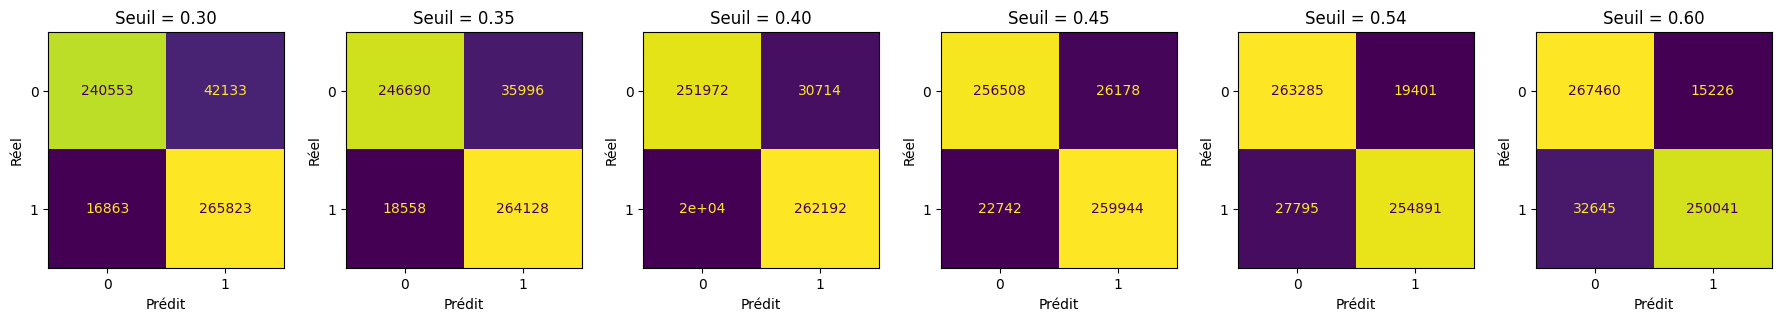

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Définir une liste de seuils à tester
thresholds = [0.3, 0.35, 0.4, 0.45, optimal_threshold, 0.6]

fig, axes = plt.subplots(1, len(thresholds), figsize=(18, 3))
for i, threshold in enumerate(thresholds):
    y_pred = (y_probs >= threshold).astype(int)

    # Calculer la matrice de confusion
    conf_matrix = confusion_matrix(y_resampled, y_pred)

    # Afficher la matrice de confusion
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
    disp.plot(ax=axes[i], cmap="viridis", colorbar=False)
    axes[i].set_title(f"Seuil = {threshold:.2f}")
    axes[i].set_xlabel("Prédit")
    axes[i].set_ylabel("Réel")

plt.tight_layout()
plt.show()

Calculons également les métriques (Précision, Spécificité et Sensibilité)

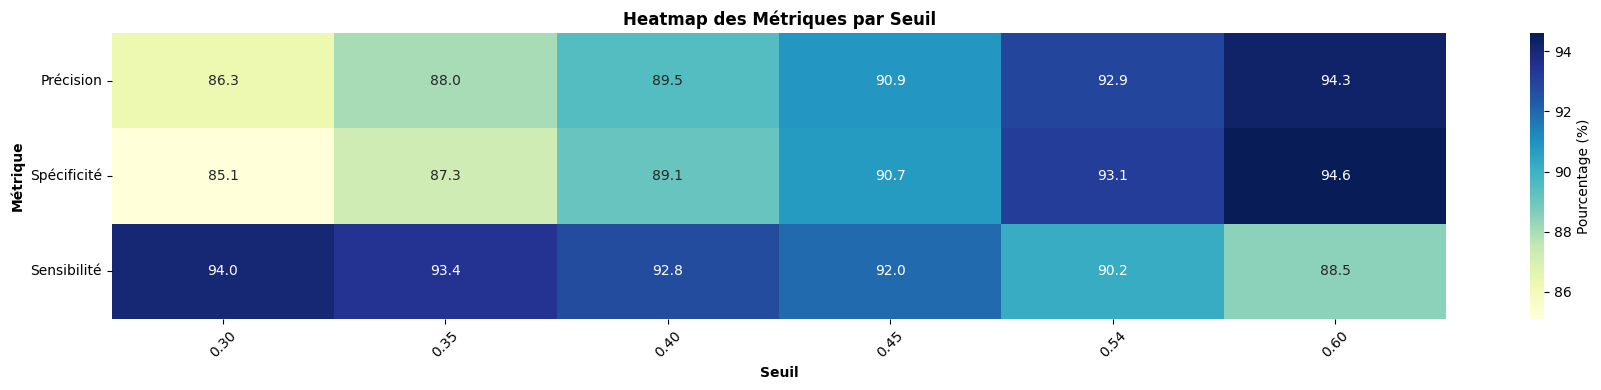

In [33]:
metrics = []
for threshold in thresholds:
    # Prédire les classes avec le seuil
    y_pred = (y_probs >= threshold).astype(int)

    # Calculer la matrice de confusion & les métriques
    tn, fp, fn, tp = confusion_matrix(y_resampled, y_pred).ravel()
    precision = tp / (tp + fp) * 100
    specificity = tn / (tn + fp) * 100
    sensitivity = tp / (tp + fn) * 100

    # Ajouter les métriques à la liste
    metrics.append(
        {
            "Seuil": f"{threshold:.2f}",
            "Précision": precision,
            "Spécificité": specificity,
            "Sensibilité": sensitivity,
        }
    )

metrics_df = pd.DataFrame(metrics)

# Pivot pour la heatmap
metrics_pivot = metrics_df.set_index("Seuil")

# Créer la heatmap
plt.figure(figsize=(18, 4))
sns.heatmap(
    metrics_pivot.T, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={"label": "Pourcentage (%)"}
)
plt.title("Heatmap des Métriques par Seuil", fontweight="bold")
plt.xlabel("Seuil", fontweight="bold")
plt.ylabel("Métrique", fontweight="bold")
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Pour rappel :
- Précision : Proportion de vrais positifs parmi les prédictions positives
- Spécificité : Proportion de vrais négatifs parmi les prédictions négatives
- Sensibilité : Proportion de vrais positifs parmi les vrais positifs réels

Reprenons notre contexte. Ici, les faux négatifs sont les plus coûteux, car ils entraînent un prêt à une personne qui aura des difficultés de paiement. A l'inverse, les faux positifs bien qu'à éviter (refus d'un prêt à tort) sont moins dommageables pour Néobanque.

Nous avons donc besoin d'un seuil avec une bonne sensibilité, tout en gardant une bonne spécificité. 
Nous partons ici sur 0,35. La spécificité de 93,4% nous permet de nous assurer d'un faible taux de faux positifs.

In [34]:
from sklearn.metrics import classification_report

# Prédire les classes avec le seuil de 0.35
y_pred = (y_probs >= 0.35).astype(int)

# Afficher le rapport de classification
print("\nRapport de Classification :")
print(
    classification_report(
        y_resampled,
        y_pred,
        target_names=["Pas de difficulté de paiement", "Difficulté de paiement"],
    )
)


Rapport de Classification :
                               precision    recall  f1-score   support

Pas de difficulté de paiement       0.93      0.87      0.90    282686
       Difficulté de paiement       0.88      0.93      0.91    282686

                     accuracy                           0.90    565372
                    macro avg       0.91      0.90      0.90    565372
                 weighted avg       0.91      0.90      0.90    565372



### Finalisation du modèle et enregistrement

Il est maintenant temps de sauvegarder notre modèle pour exploitation.

In [35]:
# Créer un dictionnaire pour stocker le modèle et le seuil
model_data = {"model": final_model, "seuil": 0.35, "preprocessor": preprocessor}

# Sauvegarder le modèle et le seuil dans un fichier
joblib.dump(model_data, "../modele_prediction_credit.joblib")

['../modele_prediction_credit.joblib']